# Q1: Sampling a 2d target

In [2]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

## Direct sampling
Let $x = r \cos\theta$ and $y = r \sin\theta$,
$$
\begin{aligned}
\tilde{P}_k(x, y)       & = (x^2 + y^2)^{\frac{k}{4} - 1} e^{-\sqrt{x^2 + y^2}/2}, \\
\tilde{P}_k(r, \theta)  & = (r^2)^{\frac{k}{4} - 1} e^{-r/2} \cdot \begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}^{-1}, \\
    & = r^{\frac{k}{2} - 2} e^{-r/2} \cdot r \\
    & = r^{\frac{k}{2} - 1} e^{-r/2}, \\
    & \propto \text{Gamma}\left(r; \alpha = \frac{k}{2}, \beta = \frac{1}{2}\right).
\end{aligned}
$$

We can sample from the gamma function to get samples for the target distribution as they are proportional

In [5]:
def sample_r(k, N=1):
    a = k/2
    b = 1/2
    return stats.gamma.rvs(a, scale=1/b, size=N)

def sample_theta(N=1):
    return stats.uniform.rvs(scale=2*np.pi, size=N)

In [7]:
def direct_sampling(k, N=100000):
    rs = sample_r(k=k, N=N)
    ts = sample_theta(N=N)

    xs = rs * np.cos(ts)
    ys = rs * np.sin(ts)

    return xs, ys

In [9]:
def target_density(x, y, k):
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    return (r2)**(k / 4 - 1) * np.exp(-r / 2)

def get_target_density_samples(k):
    x = np.linspace(-2*k, 2*k, 300)
    y = np.linspace(-2*k, 2*k, 300)
    X, Y = np.meshgrid(x, y)
    z = target_density(X, Y, k)
    z /= z.sum()
    return X, Y, z

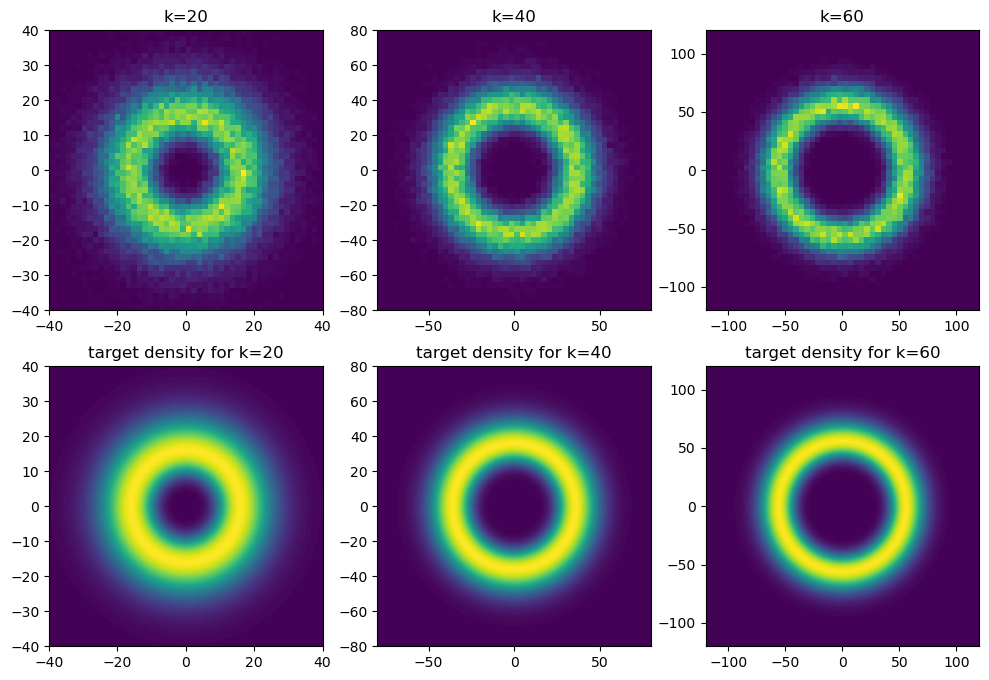

In [11]:
ks = [20, 40, 60]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, k in enumerate(ks):
    x, y = direct_sampling(k=k)
    ax[0][i].hist2d(x, y, range=[[-2*k, 2*k], [-2*k, 2*k]], bins=50, cmap='viridis')
    ax[0][i].set_title(f'k={k}')

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## Metropolis-Hastings sampler

In [81]:
def target_distribution(x: float, y: float, k: int, epsilon: float = 10e-9) -> float:
    # epsilon to avoid division error with p(0, 0) = 0
    return max((x**2 + y**2)**(k/4 - 1) * np.exp(-(np.sqrt(x**2 + y**2)) / 2), epsilon)

#### Steps of the metropolis_hastings_random_walk
1. Start at $(0, 0)$ (or any other suitable place)
2. Sample proposed $x'$ and $y'$ from a normal distribution $\mathcal{N}(\mu={x/y}, \sigma^2)$ with $\sigma$ left as a hyperparameter
3. Calculate acceptance probability $a=min(1, \frac{\bar{p_\star}(x', y')}{\bar{p_\star}(x, y)})$ where the $q$s in the formula cancel each other due to the symmetry of the normally distributed proposals (i.e. probability of going from $(x, y) \rightarrow (x', y')$ $==$ probability of $(x', y') \rightarrow (x, y)$)
4. Accept the new sample based on a uniform rv from 0 to 1 based on acceptance probability, otherwise stay in the current position for this sample

In [16]:
def metropolis_hastings_random_walk(k, N=100000, sigma=1, target_dist=target_distribution):
    x_samples, y_samples = [], []
    x, y = 0, 0
    accepted_samples = 0
    
    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        x1 = np.random.normal(loc=x, scale=sigma)
        y1 = np.random.normal(loc=y, scale=sigma)
        
        a = min(1, (target_dist(x1, y1, k=k)) / (target_dist(x, y, k=k)))
        
        if stats.uniform.rvs() < a:
            x, y = x1, y1
            accepted_samples += 1
            
        x_samples.append(x)
        y_samples.append(y)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

### identifying burn in for each k

In [19]:
ks = [20, 40, 60]
mh_xs, mh_ys = [], []
for k in ks:
    x, y = metropolis_hastings_random_walk(k=k, sigma=(0.7*k), N=100000)
    mh_xs.append(x)
    mh_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.49


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.38


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.33


We tune $\sigma$ by hand to reach a target acceptance rate within the range $(0.3, 0.5)$. This gives us an indication that the proposal sampler explores all if the target domain and also has good exploitation of high density areas in our target distribution.

It makes sense to scale sigma by $k$ as this correlates to the radius of the distribution which also scales roughly linearly according to $k$ (a can be seen in the direct sampling plots). We want a $k$ that allows us to jump from one side of the circle to the other with 

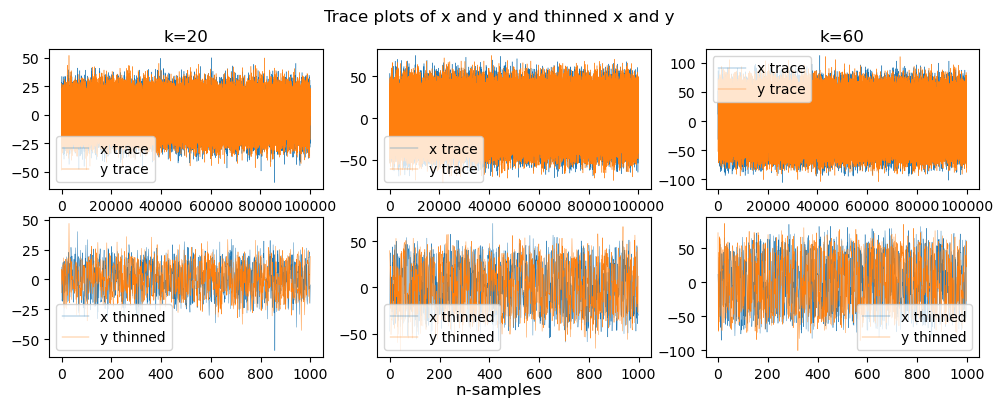

In [83]:
def moving_window_mean(data: list, window_size=100):
    return pd.Series(data).rolling(window=window_size).mean().to_numpy()[window_size-1:]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_thin = x[::100]
    y_thin = y[::100]
    ax[1][i].plot(x_thin, label='x thinned', lw=0.3)
    ax[1][i].plot(y_thin, label='y thinned', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and thinned x and y')
plt.show()

We can see that starting at $(0, 0)$, there is virtually no burn-in period. Immediately the samples randomly walk mean a mean of approximately 0 in both x and y dimensions.

We will still discard the first 10% (10,000) of samples.

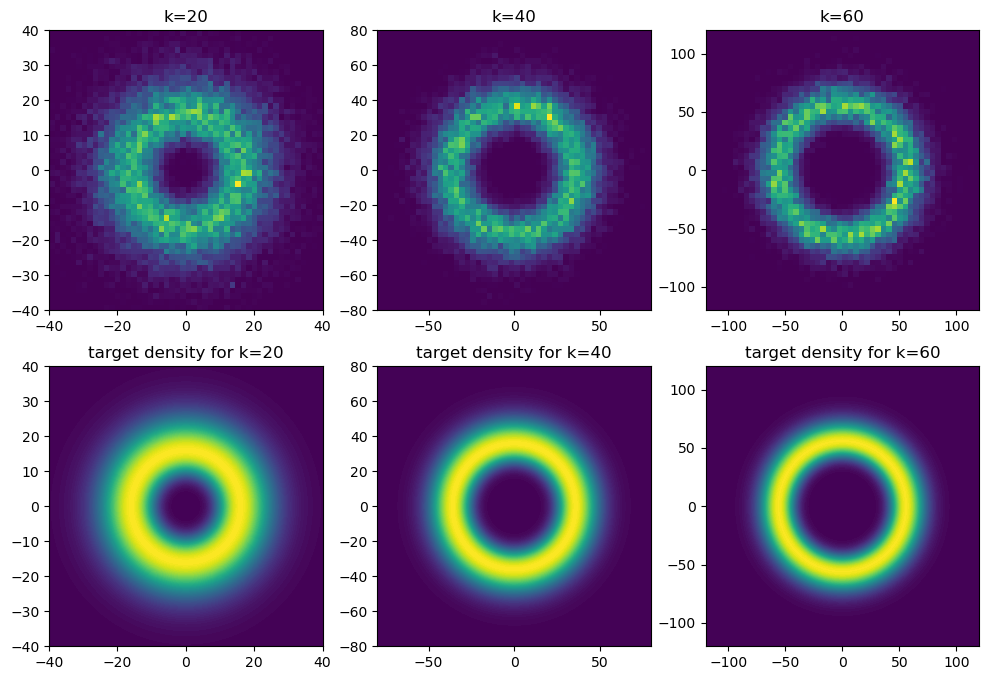

In [85]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin = 10000

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## Metropolis-adjusted Langevin algorithm (MALA)

In [28]:
def gradient_log_target(x, y, k, epsilon=10e-9):
    r = np.sqrt(np.maximum(x**2 + y**2, epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    def grad(v):
        nonlocal factor, r
        return v/r * factor
    return grad(x), grad(y)

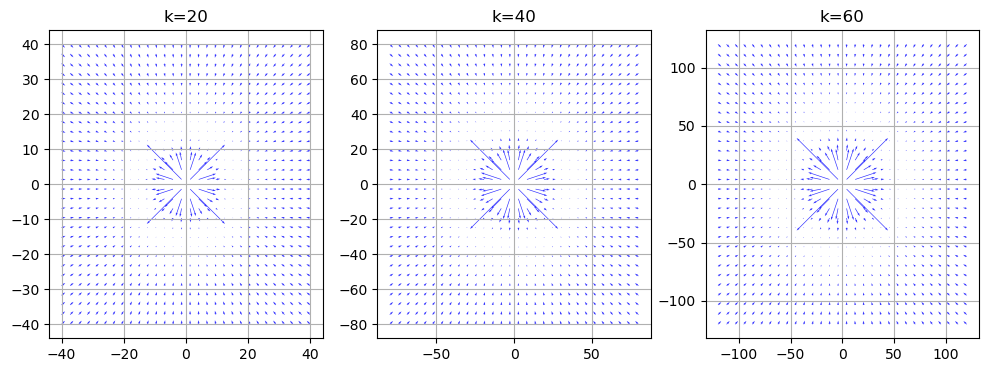

In [177]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
precision = 30
ks = [20, 40, 60]

for i, k in enumerate(ks):
    ax[i].set_title(f"k={k}")
    
    x = np.linspace(-2*k, 2*k, precision)
    y = np.linspace(-2*k, 2*k, precision)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    gx, gy = gradient_log_target(x_mesh, y_mesh, k)
    
    ax[i].quiver(x_mesh, y_mesh, gx, gy, scale=20, color='blue', alpha=0.8)
    ax[i].grid(True)

plt.show()

In [38]:
def target_distribution_vector(v: np.array, k: int, epsilon: float = 10e-9) -> float:
    return max(np.sum(v ** 2)**(k/4 - 1) * np.exp(-(np.sqrt(np.sum(v ** 2))) / 2), epsilon)
    
def gradient_log_target_vector(v, k, epsilon=1e-9):
    r = np.sqrt(np.maximum(np.sum(v**2), epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    return v/r * factor

def langevin_proposal(v, k, step_size, 
                      grad_log_target = gradient_log_target_vector):
    g = grad_log_target(v, k)
    s = step_size
    return np.random.multivariate_normal(mean=v + (s * g), cov=2 * s * np.identity(2))

def langevin_pdf(v1, v, k, step_size, 
                 grad_log_target = gradient_log_target_vector):
    # probability of going from x -> x1 given langevin proposals
    g = grad_log_target(v, k)
    s = step_size
    cov = 2 * s * np.identity(2)
    def mv_gauss(x, mean, cov_inv, det):
        diff = x - mean
        return np.exp(-0.5 * diff @ cov_inv @ diff) / (2 * np.pi * np.sqrt(det))
    return mv_gauss(v1, mean=v + (s * g), cov_inv = np.linalg.inv(cov), det=np.linalg.det(cov))
    return stats.multivariate_normal.pdf(v1, mean=v + (s * g), cov=2 * s * np.identity(2))

In [40]:
def metropolis_adjusted_langevin(k, step_size, N=100000,
                                 target_dist = target_distribution_vector, 
                                 grad_log_target = gradient_log_target_vector):
    x_samples, y_samples = [], []
    v = np.array([0, 0])
    accepted_samples = 0

    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        v1 = langevin_proposal(v, k, step_size)

        a = min(
            1,
            (target_dist(v1, k=k) * langevin_pdf(v, v1, k, step_size, grad_log_target=grad_log_target)) /
            (target_dist(v, k=k) * langevin_pdf(v1, v, k, step_size, grad_log_target=grad_log_target))
        )
        
        if stats.uniform.rvs() < a:
            v = v1
            accepted_samples += 1
            
        x_samples.append(v[0])
        y_samples.append(v[1]) 
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

In [88]:
mhl_xs, mhl_ys = [], []
for k in ks:
    x, y = metropolis_adjusted_langevin(k=k, step_size=5*k, N=100000)
    mhl_xs.append(x)
    mhl_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.48


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.42


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.41


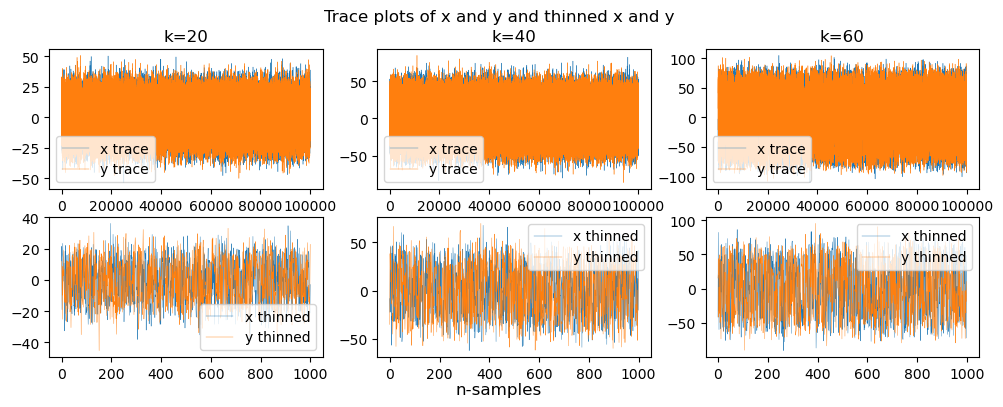

In [94]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    thin_x = x[::100]
    thin_y = y[::100]
    ax[1][i].plot(thin_x, label='x thinned', lw=0.3)
    ax[1][i].plot(thin_y, label='y thinned', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and thinned x and y')
plt.show()

We still cannot see signs of a burnin period here, however we still remove the first 10000 samples

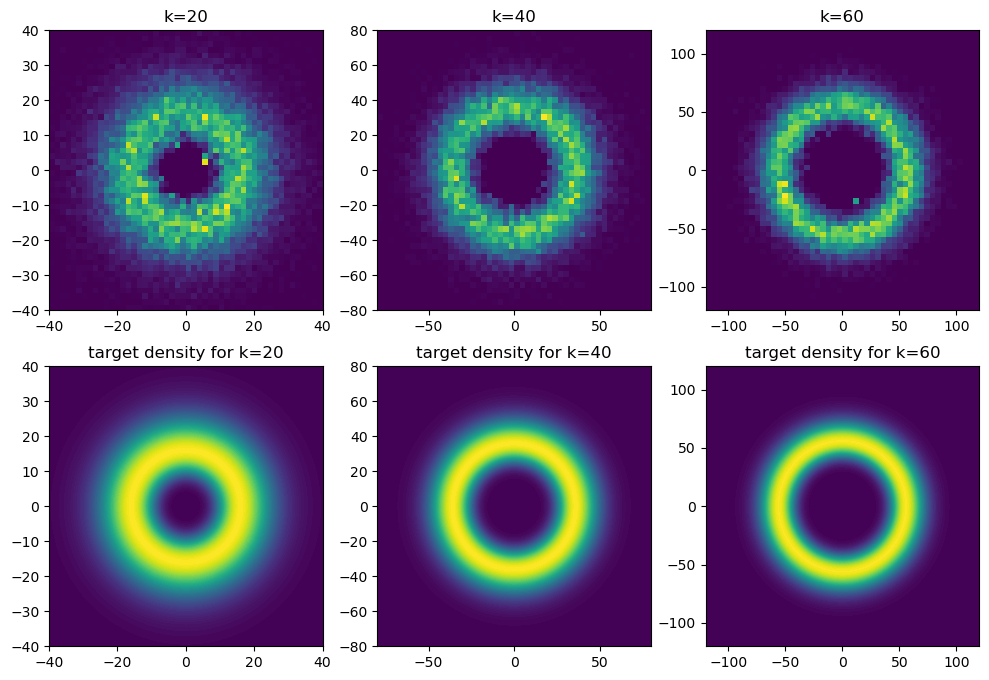

In [97]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin_percentage = 10000

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
plt.show()

## Implementation of autocorrelation estimator

In [99]:
def autocorrelation(samples: np.array, max_lag=100) -> np.array:
    x_bar = np.mean(samples)
    n = len(samples)
    var = np.var(samples)
    
    # return [COV / VAR for lag in range(1, max_range + 1)]
    return [np.sum(((samples[:n-lag] - x_bar) * (samples[lag:] - x_bar)) / (n - lag)) / var for lag in range(1, max_lag+1)]

### demonstration of autocorrelation estimator

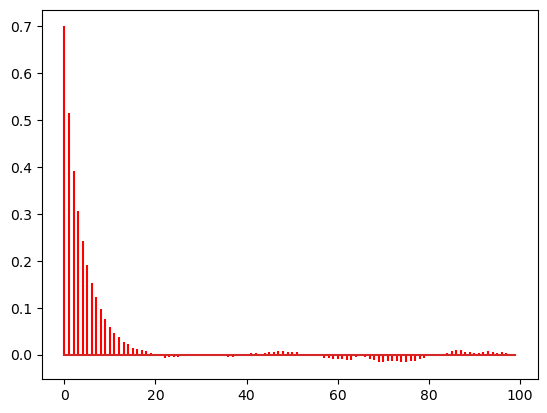

In [102]:
plt.stem(range(100), autocorrelation(mhl_xs[0][burnin:]), linefmt="red", markerfmt=" ")
plt.show()

## Computing autocorrelation on each MH sampler for $k=40$, $N=100000$, $lag=100$

In [105]:
k=40
N=100000
max_lag=100

burnin=10000

# rw samples
sigmas = [0.4, 0.8, 1, 1.2, 1.4, 1.8]
rw_samples = [metropolis_hastings_random_walk(k=k, N=N, sigma=s*k) for s in sigmas]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.54


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.35


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.30


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.25


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.15


In [107]:
# remove burn in
rw_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in rw_samples]
# calculate autocorrelation
autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in rw_samples_b]

In [114]:
# rw samples
steps = [2, 3, 4, 5, 6, 7, 8, 9]
mala_samples = [metropolis_adjusted_langevin(k=k, N=N, step_size=s*k) for s in steps]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.76


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.62


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.51


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.42


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.36


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.32


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.29


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.27


In [126]:
# remove burn in
mala_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in mala_samples]
# calculate autocorrelation
mala_autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in mala_samples_b]

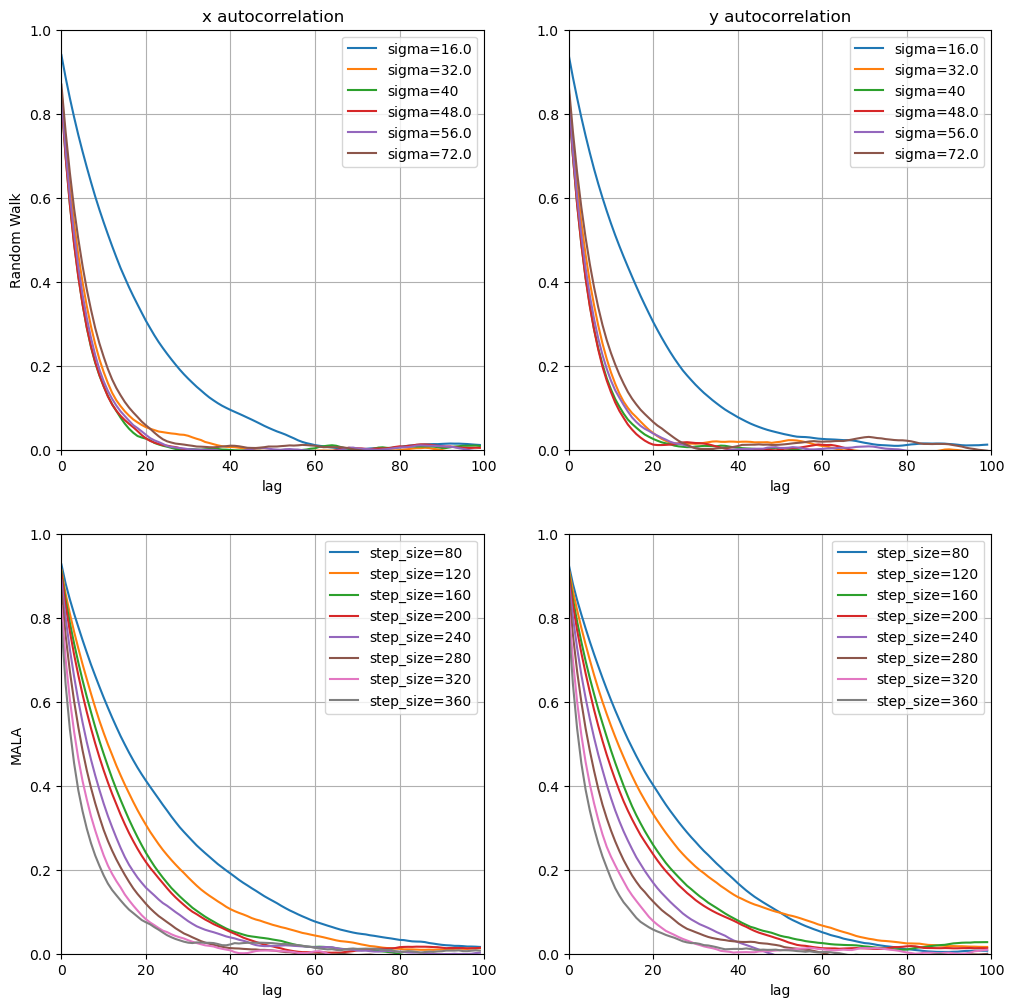

In [146]:
fix, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

for s, (corr_x, corr_y) in zip(sigmas, autocorrs):
    lbl = f'sigma={s*k}'
    
    ax[0][0].plot(corr_x, label=lbl)
    ax[0][0].set_xlim(0, 100)
    ax[0][0].set_ylim(0, 1)
    
    ax[0][1].plot(corr_y, label=lbl)
    ax[0][1].set_xlim(0, 100)
    ax[0][1].set_ylim(0, 1)

for s, (corr_x, corr_y) in zip(steps, mala_autocorrs):
    lbl = f'step_size={s*k}'
    
    ax[1][0].plot(corr_x, label=lbl)
    ax[1][0].set_xlim(0, 100)
    ax[1][0].set_ylim(0, 1)
    
    ax[1][1].plot(corr_y, label=lbl)
    ax[1][1].set_xlim(0, 100)
    ax[1][1].set_ylim(0, 1)

ax[0][0].legend()
ax[1][0].legend()
ax[0][0].set_ylabel('Random Walk')
ax[0][0].set_title('x autocorrelation')
ax[0][1].set_title('y autocorrelation')
ax[0][0].set_xlabel('lag')
ax[0][1].set_xlabel('lag')
ax[0][0].grid()
ax[1][0].grid()

ax[0][1].legend()
ax[1][1].legend()
ax[1][0].set_ylabel('MALA')
ax[1][0].set_xlabel('lag')
ax[1][1].set_xlabel('lag')
ax[0][1].grid()
ax[1][1].grid()

plt.show()

#### Comparing autocorrelation and acceptance rates
We are comparing the sampling performance and autocorrelation decay of these two samplers, Random walk (RW) and Metropolis-adjusted Langevin algorithm (MALA).

We observe that the random walk exhibits far quicker autocorrelation decay at the same lag when compared to MALA. RW across a variety of $\sigma$s tended to decay fully by about $lag=30$. Whereas MALA would often take twice as long until we reached the highest step counts. This meams RW achieves better mixing.

However, we also see that RW tends to have much lower acceptance rates than MALA. RW achieves anywhere between 50-15% acceptance rate, with a median of around 30-25%. On the other hand, MALA has a median acceptance rate of closer to 50% across the range of parameters we chose. Double the acceptance rate shows that MALA is more efficient when it comes to exploring the sample space

We can also see though from the histogram plots that MALA sometimes gets stuck in a position for an unrepresentative amount of time. This can be seen by bins in the histogram that are more lightly coloured in what should be a darker area. And this behaviour can be seen across multiple runs, implying the markov chain sampling isn't always reliable for MALA.

#### Picking the best hyperparameters:
Both algorithms required careful tuning to find the optimal hyperparameters. It makes sense to scale the step sizes by k as the radius of our target distribution gets larger.

By balancing acceptance rate and autocorrelation decay, we can see that in the selection of hyperparameters shown, the optimal $\sigma$ for RW is around 0.8-1 * k. and for MALA the step size is around 7*k. Each of these has an acceptance rate of around 0.3.

Based on this we can conclude that for this target density, the random walk performs better. 

# Q2: Bayesian Inference with a GMM prior

## Exact GMM sampler

#### Steps for exact sampler for the GMM prior

1. Choose a gaussian distribution based on weightings in the GMM. In this case all 9 distributions are all equally weighted to pick at random.
2. Sample the chosen gaussian with $\sigma^2=0.1$

In [778]:
def exact_GMM_prior_sampler(m, s0_sq, N=100000):
    indices = np.random.choice(len(m), size=N)
    samples = np.array([np.random.multivariate_normal(mean=m[i], cov=s0_sq * np.identity(2)) for i in indices ])
    return samples[:, 0], samples[:, 1]

In [780]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1

x, y = exact_GMM_prior_sampler(m, s0_sq)

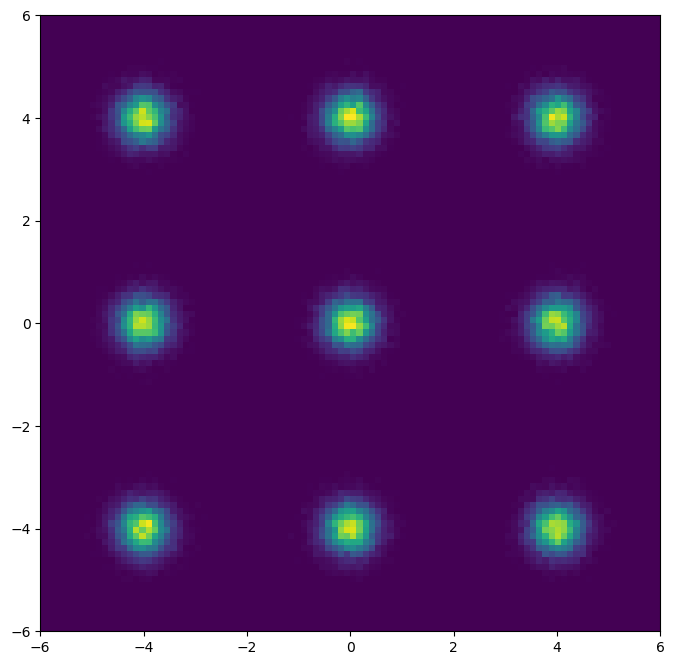

In [788]:
plt.figure(figsize=(8, 8))
plt.hist2d(x, y, bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
plt.show()

The plotted samples look as expected. We can see 9 distinct clusters, with all 9 means for the distributions given an equal weighting. We see all have been equally sampled and with the same variance.

## RW MH sampler for posterior density $p(x|y)$

$$
p(x|y) = \frac{p(y|x)p(x)}{p(y)} \propto p(y|x)p(x)
$$
Therefore we can sample the density of $likelihood \cdot prior$ in order to sample from the posterior

#### Steps for GMM Posterior RW MH

1. **Initialization**:
   - Start at an initial position $x_0 = (x_0, y_0)$. This could be $x_0 = (0, 0)$ or any suitable starting point.

2. **Proposal Sampling**:
   - At the current position $x_t = (x_t, y_t)$, propose a new position $x' = (x'_1, x'_2)$ by sampling from a normal distribution:
     $$
     x' \sim \mathcal{N}(x_t, \sigma^2 I),
     $$
     where $\sigma$ (the step size) is a tunable hyperparameter, and $I$ is the identity matrix ensuring isotropic proposals.

3. **Calculate the Acceptance Probability**:
   - Evaluate the acceptance probability $a$, which is the minimum of 1 and the ratio of the posterior densities at the proposed and current positions:
     $$
     a = \min\left(1, \frac{p(y|x')p(x')}{p(y|x_t)p(x_t)}\right),
    $$
     where:
     - $p(x')$: The GMM prior density evaluated a $x'$.
     - $p(y|x')$: The likelihood evaluated at $x'$using the observed data $y$.
   - The symmetric nature of the proposal distribution ensures the proposal densities cancel out in the acceptance probability calculation.

4. **Accept or Reject the Proposal**:
   - Generate a random number $u \sim \text{Uniform}(0, 1)$.
   - If $u \leq a$, accept the proposed sample: $x_{t+1} = x'$.
   - Otherwise, reject the proposal and stay at the current position: $x_{t+1} = x_t$.

5. **Iterate**:
   - Repeat steps 2–4 for the desired number of samples $N$, storing $x_t$ at each iteration.


In [166]:
def prior_pdf(x, m, s0_sq=0.1):
    prob = 0.
    for mu1, mu2 in m:
        p1, p2 = np.exp(-((x[0] - mu1) ** 2)/(2 * s0_sq)), np.exp(-((x[1] - mu2) ** 2)/(2 * s0_sq))
        prob += (p1 * p2) / (2 * np.pi * s0_sq)
    return prob/9
    
def likelihood_pdf(y, x, s_sq=2):
    return np.exp(-((y - x[0] - x[1])**2)/(2 * s_sq)) / np.sqrt(2 * np.pi * s_sq)

def likelihood(x, s_sq):
    return np.random.normal(loc=np.sum(x), scale=s_sq)

def rw_mh_posterior(m, s_sq, s0_sq, N=100000, burnin=10000, sigma=1, epsilon=10e-9):
    v = np.array([0, 0])
    y = 0
    
    v_samples = []
    accepted_samples = 0
    
    progress_bar = tqdm(total=N + burnin, leave=True)
    while len(v_samples) < N + burnin:
        v1 = np.random.multivariate_normal(mean=v, cov= sigma * np.identity(2))
        
        original = prior_pdf(v, m) * likelihood_pdf(y, v)
        proposal = prior_pdf(v1, m) * likelihood_pdf(y, v1)

        a = min(1, proposal/original)

        if np.random.uniform() < a:
            v = v1
            accepted_samples += 1

        v_samples.append(v)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [285]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2

rw_x, rw_y = rw_mh_posterior(m, s_sq, s0_sq, N=100000, sigma=12)

  0%|          | 0/110000 [00:00<?, ?it/s]

Acceptance rate: 0.03


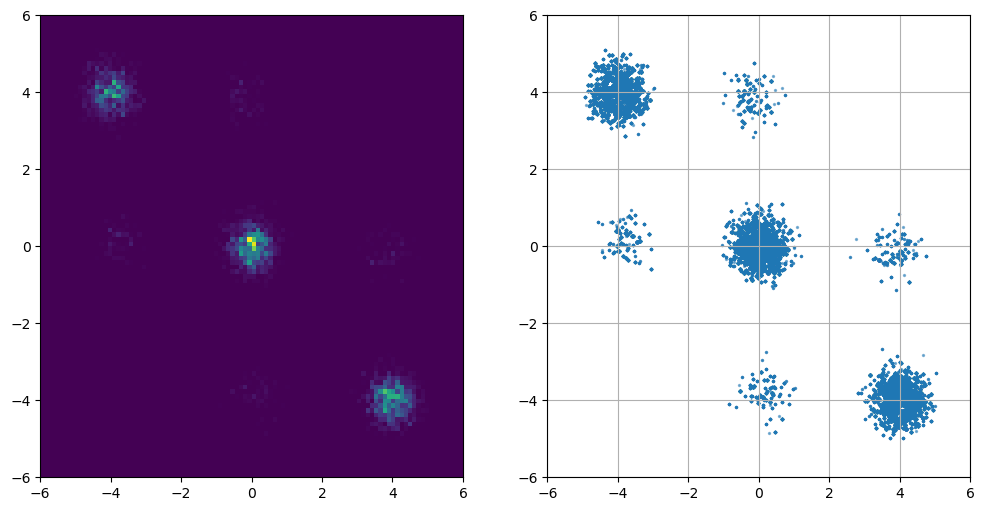

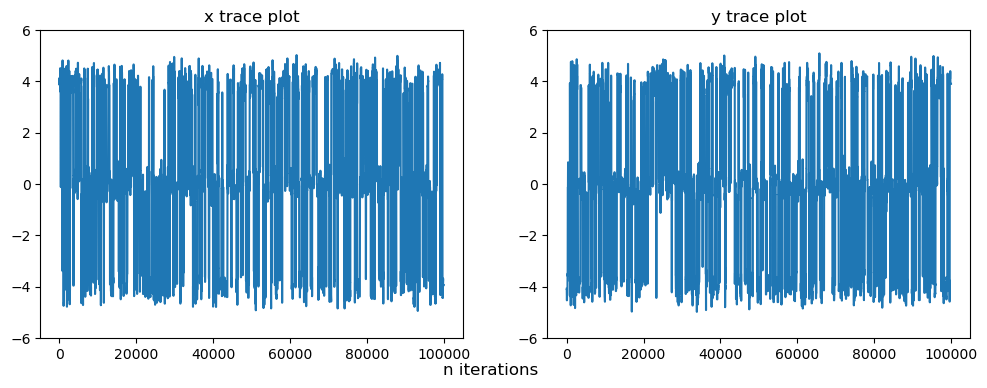

In [286]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(rw_x, rw_y, bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
ax[1].scatter(rw_x, rw_y, s=2, alpha=0.5)
ax[1].set_xlim(-6, 6)
ax[1].set_ylim(-6, 6)
ax[1].grid()
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(rw_x)
ax[0].set_ylim((-6, 6))
ax[0].set_title('x trace plot')
ax[1].plot(rw_y)
ax[1].set_ylim((-6, 6))
ax[1].set_title('y trace plot')
fig.supxlabel('n iterations')
plt.show()

We can see from the scatterplots that this samples from the posterior look different to the prior. We can see 3 dense clusters along the line $x+y=0$ at $\mu=[-4, 4], [0, 0], [4, -4]$. We also see samples from 4 sparser clusters at $[0, 4] [0, -4], [4, 0], [-4, 0]$.

The trace plots show no indication of the model gettin stuck in one cluster which is evidence of good mixing in the markov chain.

However, in the histogram plot we can see that one particular bin in the cluster centred around $[4, -4]$ is sampled an unrepresentative amount of times when compared to similar locations in other the other two dense clusters. This can sometimes be seen across multiple runs indicating sometimes the chain does get stuck for a small period.

### Metropolis-adjusted Langevin algorithm (MALA)

#### Derivation of $\nabla$ Log Prior
The prior $p(x)$ is defined as a Gaussian Mixture Model (GMM):
$$
p(x) = \frac{1}{K} \sum_{i=1}^K \mathcal{N}(x; \mu_i, \sigma_0^2 I),
$$
where:
- $K$: Number of components.
- $\mathcal{N}(x; \mu_i, \sigma_0^2 I)$ is the multivariate Gaussian density:
$$
\mathcal{N}(x; \mu_i, \sigma_0^2 I) = \frac{1}{(2\pi \sigma_0^2)^{d/2}} \exp\left(-\frac{1}{2\sigma_0^2} \|x - \mu_i\|^2\right).
$$

The log-prior is:
$$
\log p(x) = \log \left( \frac{1}{K} \sum_{i=1}^K \mathcal{N}(x; \mu_i, \sigma_0^2 I) \right).
$$

The gradient of the log-prior is:
$$
\nabla \log p(x) = \frac{\nabla p(x)}{p(x)},
$$
where:
$$
\nabla p(x) = \frac{1}{K} \sum_{i=1}^K -\frac{1}{\sigma_0^2} (x - \mu_i) p_i(x),
$$
and $p_i(x) = \mathcal{N}(x; \mu_i, \sigma_0^2 I)$.

Thus, the gradient of the log-prior is:
$$
\nabla \log p(x) = \frac{\sum_{i=1}^K -\frac{1}{\sigma_0^2} (x - \mu_i) p_i(x)}{\sum_{i=1}^K p_i(x)}.
$$

#### Derivation of $\nabla$ Log Posterior
The posterior $p(x|y)$ is proportional to the product of the likelihood and prior:
$$
p(x|y) \propto p(y|x) p(x).
$$

The log-posterior is:
$$
\log p(x|y) = \log p(y|x) + \log p(x).
$$

The gradient of the log-posterior is:
$$
\nabla \log p(x|y) = \nabla \log p(y|x) + \nabla \log p(x).
$$

- **$\nabla$ Log-Likelihood**:
  The likelihood is: $p(y|x) = \mathcal{N}(y; Hx, \sigma^2)$, where $H$ is the observation matrix. The log-likelihood is: $\log p(y|x) = -\frac{1}{2} \log(2\pi \sigma^2) - \frac{1}{2\sigma^2} (y - Hx)^2$.
  Its gradient with respect to $x$ is: $\nabla \log p(y|x) = \frac{1}{\sigma^2} H^T (y - Hx)$.

- **Combining Gradients**:
  Substitute $\nabla \log p(y|x)$ and $\nabla \log p(x)$ into $\nabla \log p(x|y)$:
  $$
  \nabla \log p(x|y) = \frac{1}{\sigma^2} H^T (y - Hx) + \frac{\sum_{i=1}^K -\frac{1}{\sigma_0^2} (x - \mu_i) p_i(x)}{\sum_{i=1}^K p_i(x)}.
  $$

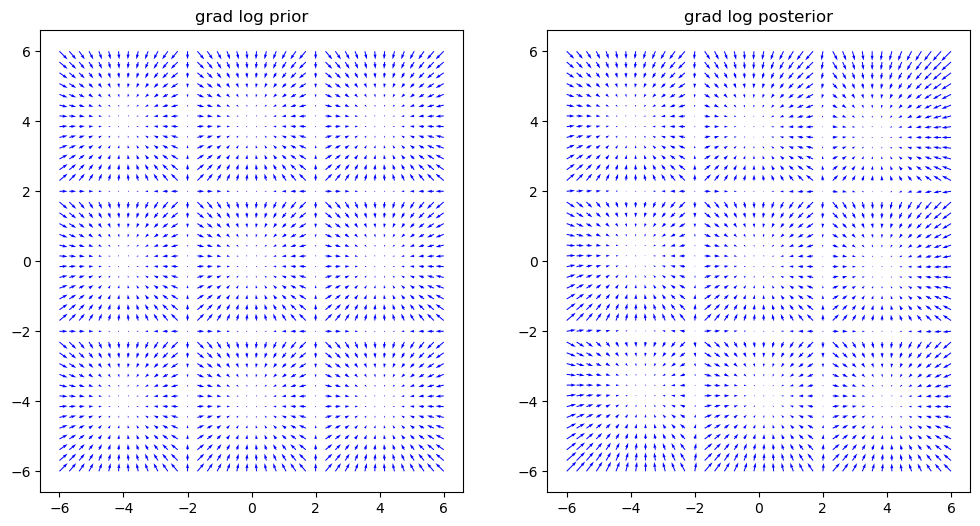

In [204]:
def grad_log_prior(x, m, s0_sq):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))

def grad_log_posterior(x, m, s0_sq, s_sq, H=np.array([1, 1])):
    grad_lp = grad_log_prior(x, m, s0_sq)
    grad_log_likelihood = ((y - H.dot(x)) / s_sq) * H
    return grad_lp + grad_log_likelihood


m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2
y = 0
precision = 40

x1, x2 = np.meshgrid(np.linspace(-6, 6, precision), np.linspace(-6, 6, precision))
grid_points = np.stack([x1.ravel(), x2.ravel()], axis=1)

prior = np.array([grad_log_prior(point, m, s0_sq) for point in grid_points]).reshape(precision, precision, 2)
posterior = np.array([grad_log_posterior(point, m, s0_sq, s_sq) for point in grid_points]).reshape(precision, precision, 2)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].quiver(x1, x2, prior[:, :, 0], prior[:, :, 1], color='blue')
ax[0].set_title('grad log prior')
ax[1].quiver(x1, x2, posterior[:, :, 0], posterior[:, :, 1], color='blue')
ax[1].set_title('grad log posterior')
plt.show()

#### Steps for MALA with GMM

1. Initialize
- Start with an initial position $x_0 = (x_0, y_0)$.
- Initialize parameters:
  - Step size $\epsilon$.
  - Observation $y$ and likelihood parameters (e.g., $H$, $\sigma^2$).


2. Compute the Gradient of the Log-Posterior $\log p(x|y) = \log p(y|x) + \log p(x)$, with:
- $\nabla \log p(y|x) = \frac{1}{\sigma^2} H^T (y - Hx),$
- $\nabla \log p(x) = \frac{\sum_{i=1}^K -\frac{1}{\sigma_0^2} (x - \mu_i) p_i(x)}{\sum_{i=1}^K p_i(x)},$
where $p_i(x) = \mathcal{N}(x; \mu_i, \sigma_0^2 I)$.

3. Use the gradient to propose a new sample $x'$ based on the current sample $x_t$:
$$
x' = x_t + \frac{\epsilon^2}{2} \nabla \log p(x_t|y) + \epsilon \cdot \eta,
$$

4. Compute the Acceptance Probability
The acceptance probability is:
$$
a = \min\left(1, \frac{p(x'|y)}{p(x_t|y)} \cdot \frac{\exp\left(-\frac{1}{2\epsilon^2} \|x_t - x' - \frac{\epsilon^2}{2} \nabla \log p(x'|y)\|^2\right)}{\exp\left(-\frac{1}{2\epsilon^2} \|x' - x_t - \frac{\epsilon^2}{2} \nabla \log p(x_t|y)\|^2\right)}\right).
$$

5. Accept or Reject
- Compute a random number $u \sim \text{Uniform}(0, 1)$.
- If $u \leq a$, accept the proposed sample: $x_{t+1} = x'$.
- Otherwise, reject the proposal and stay at the current position: $x_{t+1} = x_t$.

In [216]:
def grad_log_prior(x, m, s0_sq=0.1):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))

def grad_log_likelihood(y, x, H, s_sq=2):
    return ((y - H.dot(x)) / s_sq) * H
    
def grad_log_posterior(x, m, s0_sq=0.1, s_sq=2, H=np.array([1, 1]), y=0):
    grad_lp = grad_log_prior(x, m, s0_sq)
    grad_ll = grad_log_likelihood(0, x, H)
    return grad_lp + grad_ll
    
def gmm_langevin_proposal(v, m, step_size, s0_sq=0.1, s_sq=2):
    g = grad_log_posterior(v, m)
    return np.random.multivariate_normal(mean=v + (step_size * g), cov=2 * step_size * np.identity(2))

def gmm_langevin_pdf(v1, v, m, step_size):
    # probability of going from v -> v1 given langevin proposals
    return -np.sum((v1 - (v + step_size * grad_log_posterior(v, m)))**2)/(4*step_size)
    
def log_posterior(x, y, m):
    return np.log(prior_pdf(x, m) * likelihood_pdf(y, x))

In [218]:
def mala_mh_posterior(m, step_size, N=100000, burnin=10000, s_sq=2, s0_sq=0.1):
    v = np.array([0, 0])
    y = 0
    v_samples = []
    accepted_samples = 0
    
    progress_bar = tqdm(total=N + burnin, leave=True)
    while len(v_samples) < N + burnin:
        v1 = gmm_langevin_proposal(v, m, step_size)
        
        log_original = log_posterior(v, y, m)
        log_proposal = log_posterior(v1, y, m)
        
        log_q_prop, log_q_curr = gmm_langevin_pdf(v1, v, m, step_size), gmm_langevin_pdf(v, v1, m, step_size)
        
        log_a = (log_proposal - log_original) + (log_q_prop - log_q_curr)
        
        a = min(1, np.exp(log_a))

        if np.random.uniform() < a:
            v = v1
            accepted_samples += 1

        v_samples.append(v)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [264]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2
y = 0

mala_x, mala_y = mala_mh_posterior(m, step_size=0.15)

  0%|          | 0/110000 [00:00<?, ?it/s]

Acceptance rate: 0.37


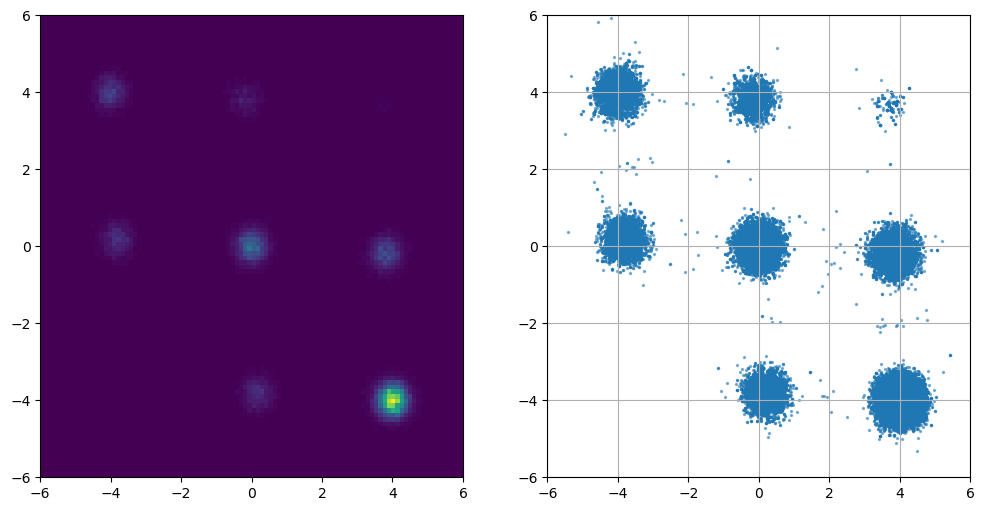

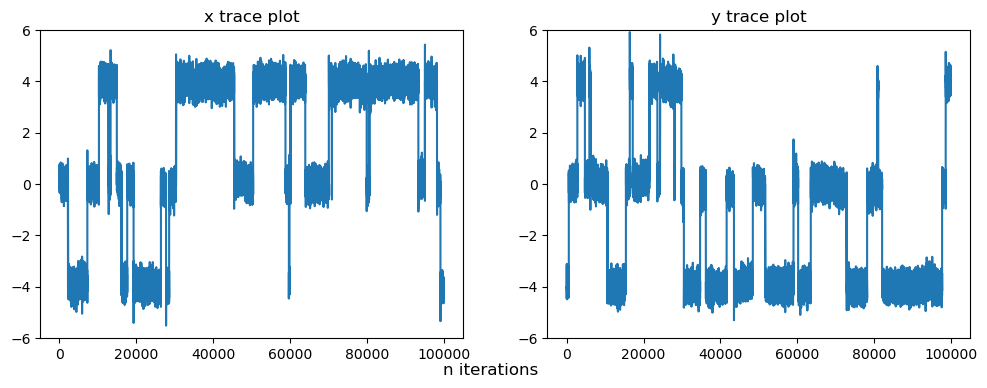

In [278]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(mala_x, mala_y, bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
ax[1].scatter(mala_x, mala_y, s=2, alpha=0.5)
ax[1].set_xlim(-6, 6)
ax[1].set_ylim(-6, 6)
ax[1].grid()
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(mala_x)
ax[0].set_ylim((-6, 6))
ax[0].set_title('x trace plot')
ax[1].plot(mala_y)
ax[1].set_ylim((-6, 6))
ax[1].set_title('y trace plot')

fig.supxlabel('n iterations')
plt.show()

We can see dense clusters centred around in 7 of the 9 means and a sparse one around $[4, -4]$  The better distribution of samples indicates better exploration of the sample space.

The trace plots show the x and y both get stuck for large periods and only a few jumps from custer to cluster relative to the random walk. This could indicate poorer mixing and the correlation between samples is likely much higher than RW.

The histogram shows that each dense clusters are more equally sampled than the random walk.

### 2.4 Unadjusted Langevin Algorithm (ULA)

#### Steps for ULA with GMM

1. Initialize
- Start with an initial position $x_0 = (x_0, y_0)$.
- Initialize parameters:
  - Step size $\epsilon$.
  - Observation $y$ and likelihood parameters (e.g., $H$, $\sigma^2$).

2. Compute the Gradient of the Log-Posterior
The log-posterior is:
$$
\log p(x|y) = \log p(y|x) + \log p(x),
$$
where:
- $\nabla \log p(y|x) = \frac{1}{\sigma^2} H^T (y - Hx),$
- $\nabla \log p(x) = \frac{\sum_{i=1}^K -\frac{1}{\sigma_0^2} (x - \mu_i) p_i(x)}{\sum_{i=1}^K p_i(x)},$

3. Update the Position $x_{t+1} = x_t + \epsilon^2 \nabla \log p(x_t|y) + \epsilon \cdot \eta$,
where:
- $\epsilon$: Step size.
- $\eta \sim \mathcal{N}(0, I)$: Random noise.


In [241]:
def ula(y, m, step, N=100000, burnin=10000, sigma_0=0.1, sigma_y=2.0, H = np.array([1.0, 1.0])):
    v = np.array([0.0, 0.0])
    v_samples = []

    progress_bar = tqdm(total=N+burnin, leave=True)
    while len(v_samples) < (N+burnin):
        # Compute gradients
        grad_p = grad_log_prior(v, m)
        grad_l = grad_log_likelihood(y, v, H)
        
        # Langevin update
        v = v + step * (grad_l + grad_p) + np.sqrt(2 * step) * np.random.normal(size=2)
        
        v_samples.append(v)
        progress_bar.update(1)

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [247]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
y = 0
step = 0.13
ula_x, ula_y = ula(y, m, step)

  0%|          | 0/110000 [00:00<?, ?it/s]

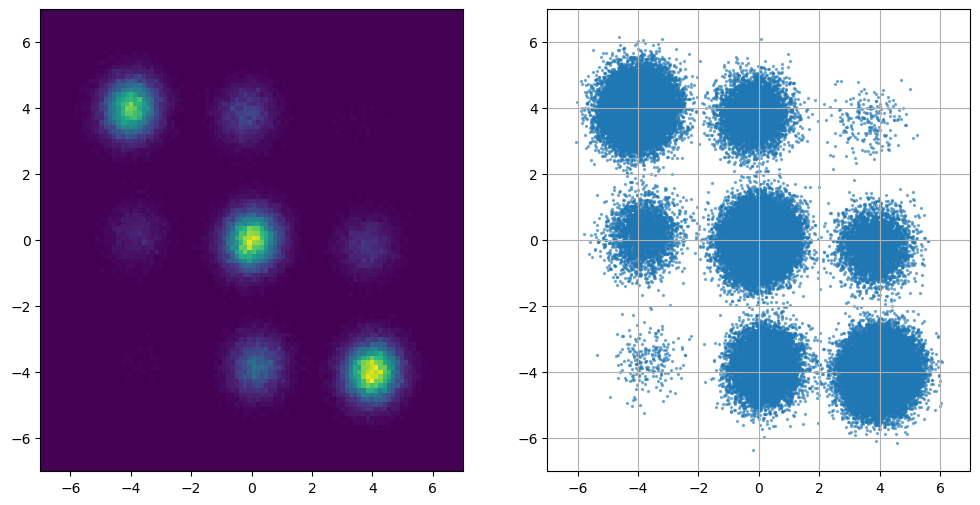

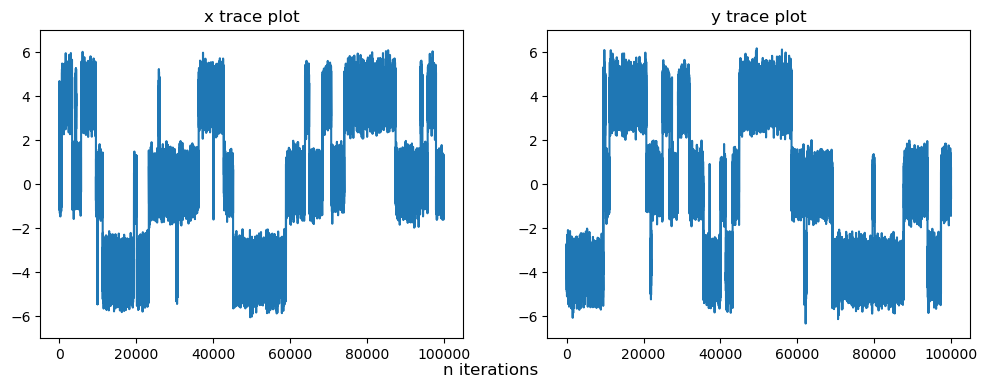

In [280]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(ula_x, ula_y, bins=100, cmap='viridis', range=[[-7, 7], [-7, 7]])
ax[1].scatter(ula_x, ula_y, s=2, alpha=0.5)
ax[1].set_xlim(-7, 7)
ax[1].set_ylim(-7, 7)
ax[1].grid()
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(ula_x)
ax[0].set_ylim((-7, 7))
ax[0].set_title('x trace plot')
ax[1].plot(ula_y)
ax[1].set_ylim((-7, 7))
ax[1].set_title('y trace plot')
fig.supxlabel('n iterations')
plt.show()

The cluster chart is similar to the MALA scatterplot. We can see 7 dense clusters with the biggest ones along the line $x+y=0$. The other 4 are less dense and the top right and bottom left clusters and more sparse. We note that a lot more samples can be seen in the corner sparse clusters and all clusters are generally larger radius than RW or MALA, indicating more exploration.

The trace plots show both dimensions getting stuck for large periods even more than MALA, and there is even less jumping between clusters. This is indication that the mixing and correlation between samples is much higher than MALA and RW indicating worse mixing of the markov chain.

### 2.5 Importance Sampling Resampler

In [260]:
H = np.array([1, 1])
s_sq = 2
s0_sq = 0.1
N = 100000
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])

prior_cov = s0_sq * np.eye(2)
prior_cov_inv = np.linalg.inv(prior_cov)
prior_det = np.linalg.det(prior_cov)

# Proposal distribution: multivaritate gaussian q(x)
proposal_mean = np.array([0, 0])
proposal_cov = 10 * np.eye(2)
proposal_cov_inv = np.linalg.inv(proposal_cov)
proposal_det = np.linalg.det(proposal_cov)

def proposal_pdf(x):
    def mv_gauss(x, mean, cov_inv, det):
        diff = x - mean
        return np.exp(-0.5 * diff @ cov_inv @ diff) / (2 * np.pi * np.sqrt(det))
    return mv_gauss(x, proposal_mean, proposal_cov_inv, proposal_det)

proposal_samples = np.random.multivariate_normal(proposal_mean, proposal_cov, size=N)

weights = np.array([likelihood_pdf(y, x) * prior_pdf(x, m) / proposal_pdf(x) for x in proposal_samples])
normalized_weights = weights / np.sum(weights)

indices = np.random.choice(range(N), size=N, p=normalized_weights)
resampled_posterior_samples = proposal_samples[indices]

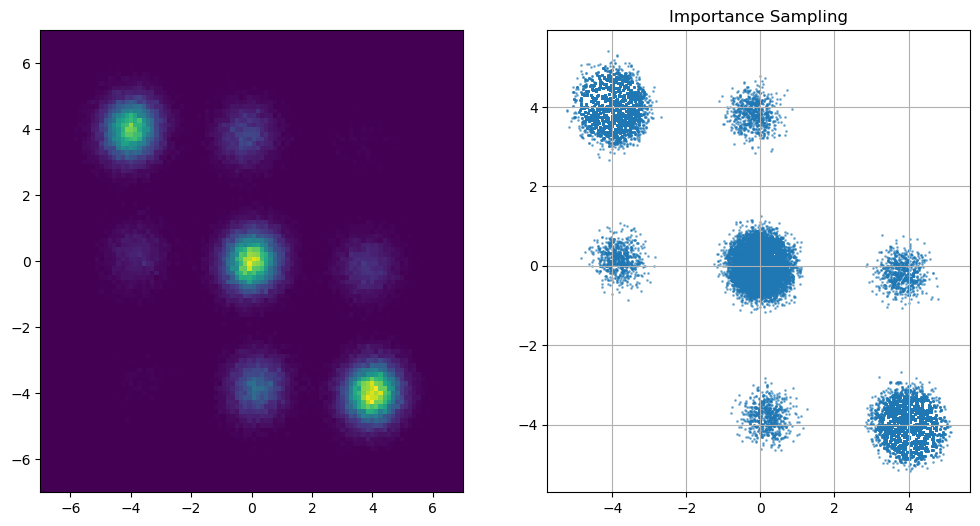

estimated posterior mean: [ 0.09657906 -0.09712594]
estimated posterior covariance:
 [[ 10.57875846 -10.25288821]
 [-10.25288821  10.54819492]]


In [274]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(ula_x, ula_y, bins=100, cmap='viridis', range=[[-7, 7], [-7, 7]])
ax[1].scatter(resampled_posterior_samples[:, 0], resampled_posterior_samples[:, 1], s=1, alpha=0.5)
ax[1].set_title("Importance Sampling")
ax[1].grid()
plt.show()

# posterior mean and cov
posterior_mean = np.average(proposal_samples, weights=normalized_weights, axis=0)
posterior_cov = np.cov(proposal_samples.T, aweights=normalized_weights)
print("estimated posterior mean:", posterior_mean)
print("estimated posterior covariance:\n", posterior_cov)

The importance sampled scatterplot shows the true distribution of the posterior density. Like we have been seeing, there are three large dense clusters centred at $\mu=[-4, 4], [0, 0], [4, -4]$. Each of these has a radius of around 1. There are also 4 more smaller clusters at $[0, 4] [0, -4], [4, 0], [-4, 0]$ also of radius 1. Note that there are no samples at $[4, 4]$ and $[-4, -4]$ which we can use for performance comparison between all of the sampling techniques.

The random walk has the right number of clusters with no samples in the top left and bottom right (and this is seen over multiple runs). However comparatively there are less samples in the smaller clusters than there should be and more in the denser clusters.

The MALA has a better distribution across the clusters and of the correct radius but there are samples in the top left. Across multiple runs we regularly get samples in the top left and bottom right areas meaning there are samples coming out of MALA that are not proportional to the true distribution.

The ULA has larger clusters with a radius of around 1.8. There are also a larger proportion of samples in the top left and bottom right areas which is not a good sign. Overall this probably has the worse performance of the three samplers.

In conclusion, with the balance mixing seen in the of trace plots and the distribution of samples in the scatterplots, I would say MALA is the best sampler for this GMM (in contrast to question 1).